# Exploratory Data Analysis: Merged Dyadic Panel

This notebook explores the merged dataset containing bilateral relationships and journalist killings.

**Contents:**
1. Data Loading & Overview
2. Data Types and Structure
3. Distributions of Variables
4. Outlier Detection and Handling Strategy
5. Missingness Analysis (MCAR/MAR/MNAR)
6. Summary & Recommendations

In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))
plt.style.use('seaborn-v0_8-whitegrid')


np.random.seed(10)

---
## 1. Data Loading & Overview

In [11]:

panel = pd.read_csv('/Users/mac/Documents/GitHub/Violent-Offenders-GPV---CSSci-/data/merged/panel_dyadic_1992_2013.csv')

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {panel.shape[0]:,} rows × {panel.shape[1]} columns")
print(f"\nYear range: {panel['year'].min()} - {panel['year'].max()}")
print(f"Unique senders: {panel['sender_iso3'].nunique()}")
print(f"Unique recipients: {panel['recipient_iso3'].nunique()}")

DATASET OVERVIEW
Shape: 59,618 rows × 14 columns

Year range: 1992 - 2013
Unique senders: 147
Unique recipients: 214


In [12]:

panel.head(10)

,sender_iso3,recipient_iso3,year,arms_tiv,bilateral_debt,ucdp_troops,ucdp_weapons,ucdp_training,ucdp_funding,bilateral_aid,colonial_tie,journalist_killings,oda_received,us_intervention
0,ABW,ISR,1996,17.80,NaN,0,0,0,0,NaN,0,0.00,"2,216,619,999.30",0
1,AGO,CIV,2002,1.72,NaN,0,0,0,0,NaN,0,0.00,"836,099,980.75",1
2,ALB,BFA,2011,1.20,NaN,0,0,0,0,NaN,0,0.00,"594,560,005.38",0
3,ARE,BHR,2010,14.80,NaN,0,0,0,0,"53,272,734.00",0,0.00,NaN,0
4,ARE,BIH,1996,6.48,NaN,0,0,0,0,NaN,0,0.00,"666,760,000.73",1
5,ARE,BIH,1997,37.40,NaN,0,0,0,0,NaN,0,0.00,"738,329,998.61",1
6,ARE,IDN,1995,26.44,NaN,0,0,0,0,NaN,0,0.00,"1,243,669,978.88",0
7,ARE,IRQ,2004,2.82,NaN,0,0,0,0,NaN,0,38.00,"4,605,340,006.71",1
8,ARE,IRQ,2005,2.04,NaN,0,0,0,0,NaN,0,27.00,"22,028,320,132.72",1
9,ARE,JOR,2005,9.00,NaN,0,0,0,0,NaN,0,0.00,"478,909,986.58",0


---
## 2. Data Types and Structure

In [13]:

print("DATA TYPES")
print("-"*40)
print(panel.dtypes)

DATA TYPES
----------------------------------------
sender_iso3             object
recipient_iso3          object
year                     int64
arms_tiv               float64
bilateral_debt         float64
ucdp_troops              int64
ucdp_weapons             int64
ucdp_training            int64
ucdp_funding             int64
bilateral_aid          float64
colonial_tie             int64
journalist_killings    float64
oda_received           float64
us_intervention          int64
dtype: object


In [14]:
#categorize variables by type
var_types = {
    'Identifiers': ['sender_iso3', 'recipient_iso3', 'year'],
    'Continuous': ['arms_tiv', 'bilateral_aid', 'bilateral_debt', 'oda_received'],
    'Count (Target)': ['journalist_killings'],
    'Binary': ['ucdp_troops', 'ucdp_weapons', 'ucdp_training', 'ucdp_funding', 
               'colonial_tie', 'us_intervention']
}

print("\nVARIABLE CLASSIFICATION")
print("-"*40)
for vtype, vars in var_types.items():
    print(f"\n{vtype}:")
    for v in vars:
        print(f"  - {v}")


VARIABLE CLASSIFICATION
----------------------------------------

Identifiers:
  - sender_iso3
  - recipient_iso3
  - year

Continuous:
  - arms_tiv
  - bilateral_aid
  - bilateral_debt
  - oda_received

Count (Target):
  - journalist_killings

Binary:
  - ucdp_troops
  - ucdp_weapons
  - ucdp_training
  - ucdp_funding
  - colonial_tie
  - us_intervention


---
## 3. Distributions of Variables

### 3.1 Continuous Variables

In [15]:
#summary stats for continuous variables
continuous_vars = ['arms_tiv', 'bilateral_aid', 'bilateral_debt', 'oda_received', 'journalist_killings']

summary_stats = []
for var in continuous_vars:
    data = panel[var].dropna()
    summary_stats.append({
        'Variable': var,
        'Count': len(data),
        'Mean': data.mean(),
        'Median': data.median(),
        'Std': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'Skewness': data.skew()
    })

summary_df = pd.DataFrame(summary_stats)
print("CONTINUOUS VARIABLE SUMMARY")
print(summary_df.to_string(index=False))

CONTINUOUS VARIABLE SUMMARY
           Variable  Count           Mean         Median              Std             Min               Max  Skewness
           arms_tiv  59618           8.85           0.00            76.99            0.00          3,895.20     20.82
      bilateral_aid  49448  36,092,240.45   2,674,032.50   192,974,530.51   -3,976,426.00 11,118,682,959.00     21.14
     bilateral_debt  13149 432,280,158.05  51,017,247.50 1,558,757,231.41            0.00 30,895,965,631.80      9.31
       oda_received  55447 500,209,920.16 230,950,001.38 1,058,208,891.10 -955,079,969.86 22,028,320,132.72     10.27
journalist_killings  59618           0.67           0.00             3.32            0.00             55.00     10.83


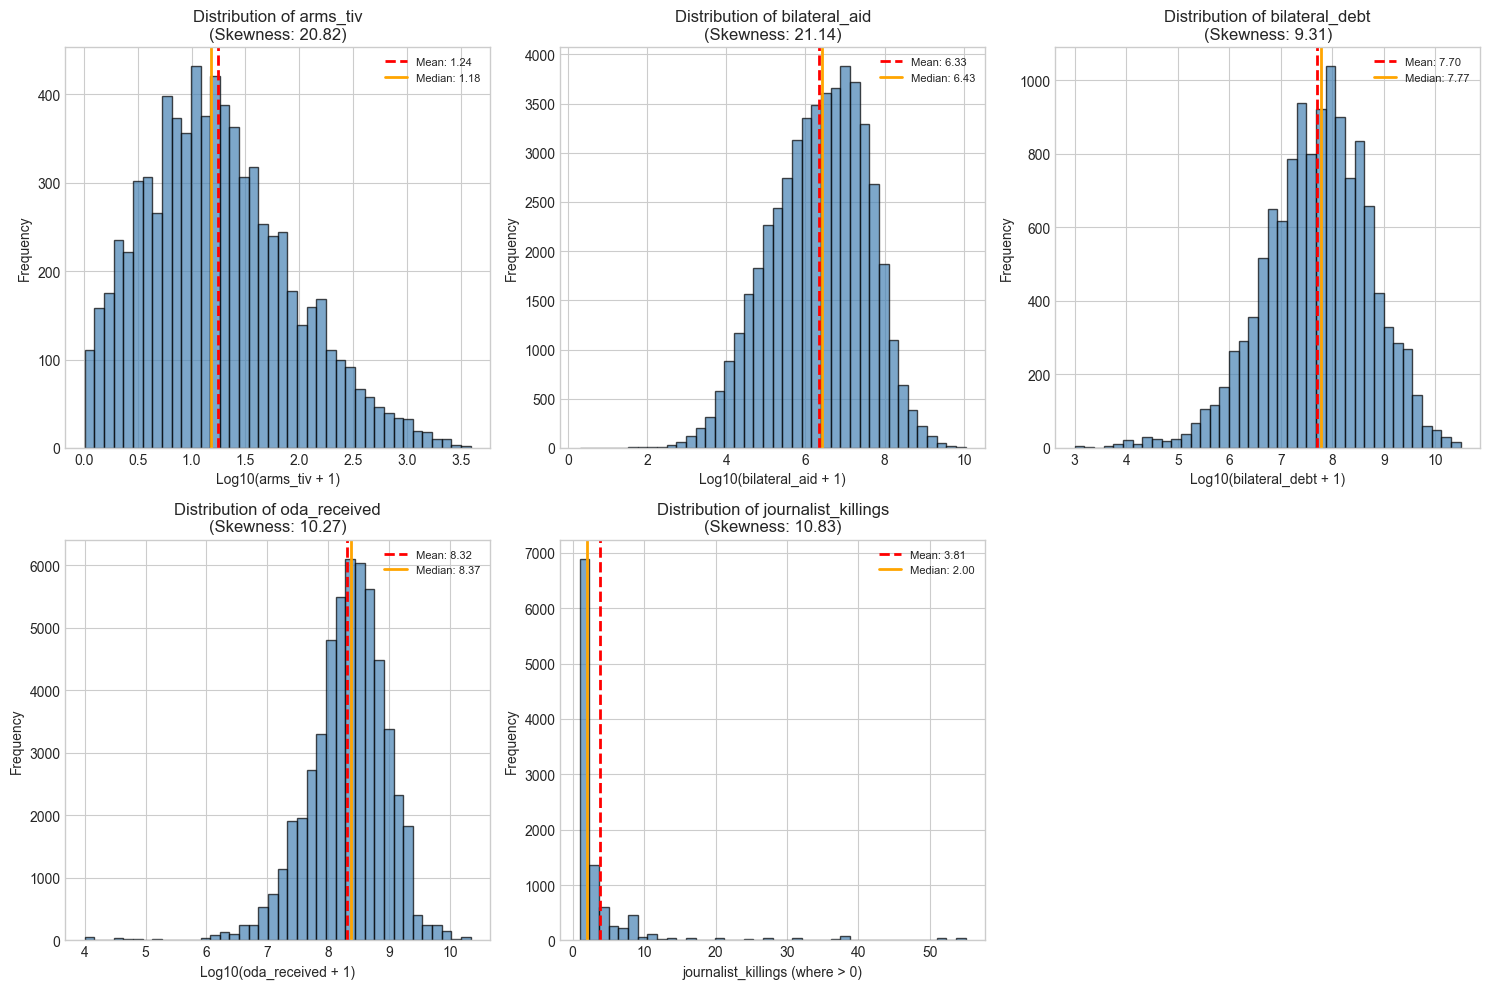


→ All continuous variables are highly right-skewed (skewness > 9)
→ Recommendation: Use log transformations for modeling


In [16]:
# Distribution plots for continuous variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(continuous_vars):
    ax = axes[i]
    data = panel[var].dropna()
    
    # Use log scale for highly skewed data
    if var != 'journalist_killings':
        data_plot = np.log10(data[data > 0] + 1)
        xlabel = f'Log10({var} + 1)'
    else:
        data_plot = data[data > 0]
        xlabel = f'{var} (where > 0)'
    
    ax.hist(data_plot, bins=40, color='steelblue', edgecolor='black', alpha=0.7)
    ax.axvline(data_plot.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data_plot.mean():.2f}')
    ax.axvline(data_plot.median(), color='orange', linestyle='-', linewidth=2, label=f'Median: {data_plot.median():.2f}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {var}\n(Skewness: {data.skew():.2f})')
    ax.legend(fontsize=8)

# Hide empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('../figures/eda_distributions_continuous.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n→ All continuous variables are highly right-skewed (skewness > 9)")
print("→ Recommendation: Use log transformations for modeling")

### 3.2 Target Variable: Journalist Killings

In [17]:
# Detailed analysis of target variable
print("TARGET VARIABLE: journalist_killings")
print("="*50)

killings = panel['journalist_killings']

print(f"\nBasic Statistics:")
print(f"  Total observations: {len(killings):,}")
print(f"  Zeros: {(killings == 0).sum():,} ({100*(killings == 0).sum()/len(killings):.1f}%)")
print(f"  Non-zeros: {(killings > 0).sum():,} ({100*(killings > 0).sum()/len(killings):.1f}%)")
print(f"  Mean: {killings.mean():.2f}")
print(f"  Variance: {killings.var():.2f}")
print(f"  Variance/Mean ratio: {killings.var()/killings.mean():.2f}")

print(f"\n→ Variance >> Mean indicates OVERDISPERSION")
print(f"→ Recommendation: Use Negative Binomial regression (not Poisson)")

TARGET VARIABLE: journalist_killings

Basic Statistics:
  Total observations: 59,618
  Zeros: 49,117 (82.4%)
  Non-zeros: 10,501 (17.6%)
  Mean: 0.67
  Variance: 11.02
  Variance/Mean ratio: 16.42

→ Variance >> Mean indicates OVERDISPERSION
→ Recommendation: Use Negative Binomial regression (not Poisson)


In [18]:
# Top recipient-years by journalist killings
print("\nTOP 10 RECIPIENT-YEARS BY JOURNALIST KILLINGS")
print("-"*50)

top_killings = panel.groupby(['recipient_iso3', 'year'])['journalist_killings'].first().reset_index()
top_killings = top_killings[top_killings['journalist_killings'] > 0]
top_killings = top_killings.nlargest(10, 'journalist_killings')
print(top_killings.to_string(index=False))


TOP 10 RECIPIENT-YEARS BY JOURNALIST KILLINGS
--------------------------------------------------
recipient_iso3  year  journalist_killings
           IRQ  2006                55.00
           IRQ  2007                51.00
           IRQ  2004                38.00
           PHL  2009                38.00
           SYR  2012                37.00
           SYR  2013                32.00
           IRQ  2005                27.00
           DZA  1995                24.00
           IRQ  2003                21.00
           RWA  1994                20.00


### 3.3 Binary Variables

In [19]:
# Binary variable distributions
binary_vars = ['ucdp_troops', 'ucdp_weapons', 'ucdp_training', 'ucdp_funding', 
               'colonial_tie', 'us_intervention']

print("BINARY VARIABLE DISTRIBUTIONS")
print("-"*50)

binary_stats = []
for var in binary_vars:
    ones = (panel[var] == 1).sum()
    zeros = (panel[var] == 0).sum()
    pct = 100 * ones / len(panel)
    binary_stats.append({'Variable': var, 'Ones': ones, 'Zeros': zeros, 'Ones %': pct})
    print(f"{var}: {ones:,} ones ({pct:.2f}%), {zeros:,} zeros")

print("\n→ All binary variables are sparse (< 8% positive)")
print("→ This is expected: most country pairs don't have these relationships")

BINARY VARIABLE DISTRIBUTIONS
--------------------------------------------------
ucdp_troops: 20 ones (0.03%), 59,598 zeros
ucdp_weapons: 665 ones (1.12%), 58,953 zeros
ucdp_training: 1,018 ones (1.71%), 58,600 zeros
ucdp_funding: 526 ones (0.88%), 59,092 zeros
colonial_tie: 2,771 ones (4.65%), 56,847 zeros
us_intervention: 4,354 ones (7.30%), 55,264 zeros

→ All binary variables are sparse (< 8% positive)
→ This is expected: most country pairs don't have these relationships


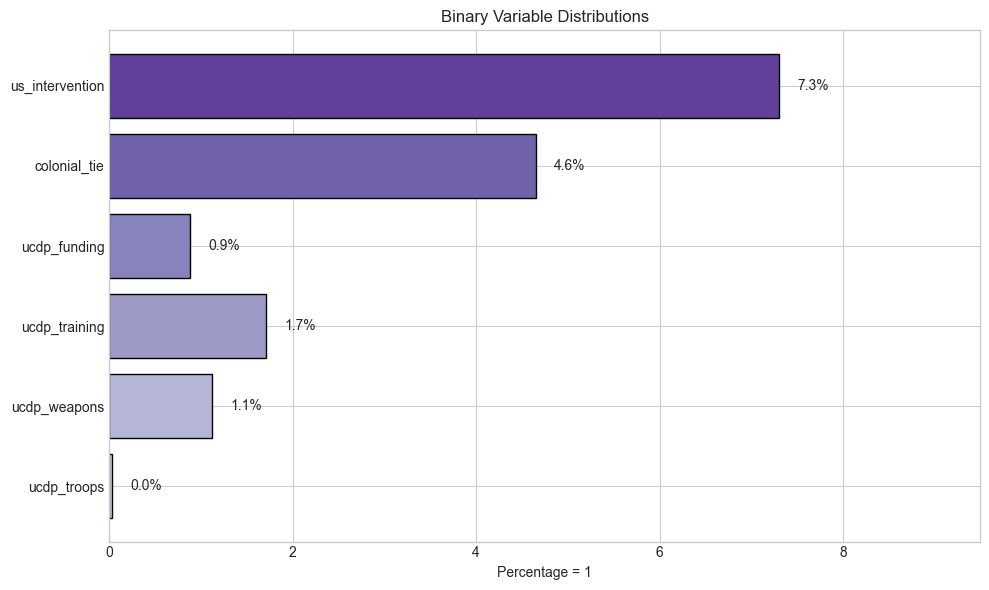

In [20]:
# Visualize binary variables
fig, ax = plt.subplots(figsize=(10, 6))

binary_df = pd.DataFrame(binary_stats)
colors = plt.cm.Purples(np.linspace(0.3, 0.8, len(binary_vars)))

bars = ax.barh(binary_df['Variable'], binary_df['Ones %'], color=colors, edgecolor='black')
ax.set_xlabel('Percentage = 1')
ax.set_title('Binary Variable Distributions')

# Add percentage labels
for bar, pct in zip(bars, binary_df['Ones %']):
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=10)

ax.set_xlim(0, max(binary_df['Ones %']) * 1.3)
plt.tight_layout()
plt.savefig('../figures/eda_distributions_binary.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Outlier Detection and Handling Strategy

In [21]:
# Outlier detection using IQR method
print("OUTLIER DETECTION (IQR Method)")
print("="*60)

outlier_results = []

for var in continuous_vars:
    data = panel[var].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct = 100 * len(outliers) / len(data)
    
    outlier_results.append({
        'Variable': var,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'N Outliers': len(outliers),
        'Outlier %': outlier_pct
    })
    
    print(f"\n{var}:")
    print(f"  IQR: {IQR:,.2f}")
    print(f"  Bounds: [{lower_bound:,.2f}, {upper_bound:,.2f}]")
    print(f"  Outliers: {len(outliers):,} ({outlier_pct:.1f}%)")
    if len(outliers) > 0:
        print(f"  Max outlier value: {outliers.max():,.2f}")

outlier_df = pd.DataFrame(outlier_results)

OUTLIER DETECTION (IQR Method)

arms_tiv:
  IQR: 0.00
  Bounds: [0.00, 0.00]
  Outliers: 7,530 (12.6%)
  Max outlier value: 3,895.20

bilateral_aid:
  IQR: 16,777,031.50
  Bounds: [-24,847,982.25, 42,260,143.75]
  Outliers: 6,893 (13.9%)
  Max outlier value: 11,118,682,959.00

bilateral_debt:
  IQR: 235,013,965.40
  Bounds: [-344,073,678.10, 595,982,183.50]
  Outliers: 1,686 (12.8%)
  Max outlier value: 30,895,965,631.80

oda_received:
  IQR: 454,590,000.99
  Bounds: [-592,614,998.59, 1,225,745,005.39]
  Outliers: 4,968 (9.0%)
  Max outlier value: 22,028,320,132.72

journalist_killings:
  IQR: 0.00
  Bounds: [0.00, 0.00]
  Outliers: 10,501 (17.6%)
  Max outlier value: 55.00


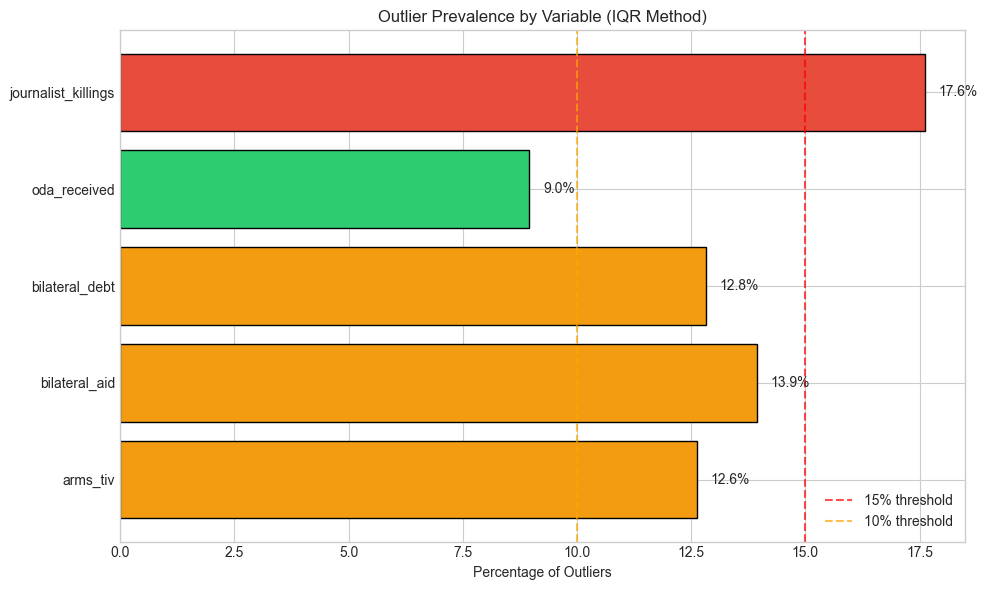

In [22]:
# Visualize outlier prevalence
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#e74c3c' if x > 15 else '#f39c12' if x > 10 else '#2ecc71' 
          for x in outlier_df['Outlier %']]

bars = ax.barh(outlier_df['Variable'], outlier_df['Outlier %'], color=colors, edgecolor='black')
ax.axvline(15, color='red', linestyle='--', alpha=0.7, label='15% threshold')
ax.axvline(10, color='orange', linestyle='--', alpha=0.7, label='10% threshold')
ax.set_xlabel('Percentage of Outliers')
ax.set_title('Outlier Prevalence by Variable (IQR Method)')
ax.legend()

# Add percentage labels
for bar, pct in zip(bars, outlier_df['Outlier %']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/eda_outliers.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# Examine extreme values in context
print("\nEXTREME VALUES IN CONTEXT")
print("="*60)

print("\nTop 10 Arms Transfers (TIV):")
print(panel.nlargest(10, 'arms_tiv')[['sender_iso3', 'recipient_iso3', 'year', 'arms_tiv']].to_string(index=False))

print("\n→ These are real major arms deals (Russia→India, Russia→China, USA→Taiwan)")
print("→ NOT data errors - represent genuine extreme events")


EXTREME VALUES IN CONTEXT

Top 10 Arms Transfers (TIV):
sender_iso3 recipient_iso3  year  arms_tiv
        RUS            IND  2012  3,895.20
        RUS            IND  2013  3,750.25
        RUS            CHN  2005  3,066.00
        USA            TWN  1997  2,966.31
        RUS            CHN  2004  2,893.00
        RUS            CHN  2002  2,509.00
        RUS            IND  2011  2,501.10
        RUS            CHN  2001  2,463.25
        USA            JPN  1992  2,449.82
        RUS            CHN  2006  2,444.50

→ These are real major arms deals (Russia→India, Russia→China, USA→Taiwan)
→ NOT data errors - represent genuine extreme events


### Outlier Handling Strategy

**Assessment:**
- 10-18% of values flagged as outliers across continuous variables
- These represent **real extreme events**, not data errors:
  - Iraq 2006-2007: Peak of Iraq War violence against journalists
  - Russia→India/China arms deals: Major geopolitical transfers
  - Large aid flows to conflict zones

**Strategy:**
1. **Keep outliers** - they represent the phenomena we're studying
2. **Use log transformations** - reduces influence of extreme values
3. **Use robust regression methods** - negative binomial handles overdispersion
4. **Sensitivity analysis** - run models with and without top 1% to check stability

---
## 5. Missingness Analysis (MCAR/MAR/MNAR)

In [24]:
# Overall missingness summary
print("MISSINGNESS SUMMARY")
print("="*60)

missing_summary = pd.DataFrame({
    'Variable': panel.columns,
    'Non-null': panel.notna().sum().values,
    'Missing': panel.isna().sum().values,
    'Missing %': (100 * panel.isna().sum() / len(panel)).values
}).sort_values('Missing %', ascending=False)

print(missing_summary.to_string(index=False))

MISSINGNESS SUMMARY
           Variable  Non-null  Missing  Missing %
     bilateral_debt     13149    46469      77.94
      bilateral_aid     49448    10170      17.06
       oda_received     55447     4171       7.00
        sender_iso3     59618        0       0.00
     recipient_iso3     59618        0       0.00
               year     59618        0       0.00
           arms_tiv     59618        0       0.00
        ucdp_troops     59618        0       0.00
       ucdp_weapons     59618        0       0.00
      ucdp_training     59618        0       0.00
       ucdp_funding     59618        0       0.00
       colonial_tie     59618        0       0.00
journalist_killings     59618        0       0.00
    us_intervention     59618        0       0.00


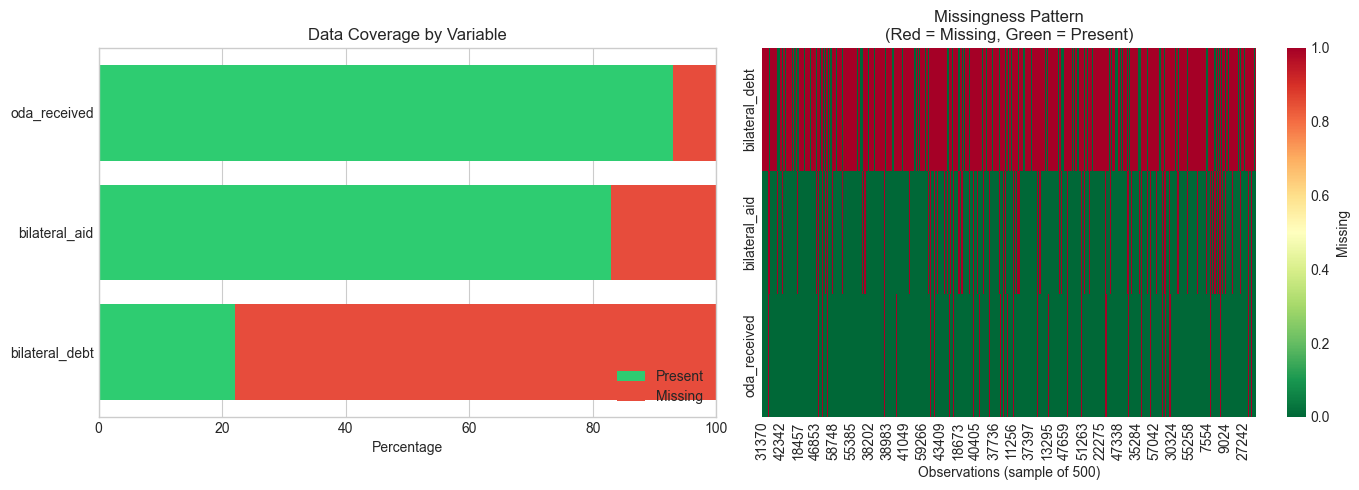

In [25]:
# Visualize missingness
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar chart of missingness
ax1 = axes[0]
vars_with_missing = missing_summary[missing_summary['Missing %'] > 0]['Variable'].tolist()
vars_with_missing = [v for v in vars_with_missing if v in continuous_vars]

present_pct = [100 - missing_summary[missing_summary['Variable'] == v]['Missing %'].values[0] for v in vars_with_missing]
missing_pct = [missing_summary[missing_summary['Variable'] == v]['Missing %'].values[0] for v in vars_with_missing]

ax1.barh(vars_with_missing, present_pct, color='#2ecc71', label='Present')
ax1.barh(vars_with_missing, missing_pct, left=present_pct, color='#e74c3c', label='Missing')
ax1.set_xlabel('Percentage')
ax1.set_title('Data Coverage by Variable')
ax1.legend(loc='lower right')
ax1.set_xlim(0, 100)

# Right: Missingness pattern heatmap
ax2 = axes[1]
sample = panel.sample(min(500, len(panel)), random_state=42)
miss_cols = ['bilateral_debt', 'bilateral_aid', 'oda_received']
miss_matrix = sample[miss_cols].isna().astype(int)

sns.heatmap(miss_matrix.T, cmap='RdYlGn_r', cbar_kws={'label': 'Missing'}, 
            ax=ax2, yticklabels=miss_cols)
ax2.set_xlabel('Observations (sample of 500)')
ax2.set_title('Missingness Pattern\n(Red = Missing, Green = Present)')

plt.tight_layout()
plt.savefig('../figures/eda_missingness_overview.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.1 Bilateral Debt Missingness (77.9% missing)

In [26]:
# Analyze bilateral debt missingness
print("BILATERAL DEBT MISSINGNESS ANALYSIS")
print("="*60)

debt_present = panel[panel['bilateral_debt'].notna()]
debt_missing = panel[panel['bilateral_debt'].isna()]

print(f"Rows WITH debt data: {len(debt_present):,}")
print(f"Rows WITHOUT debt data: {len(debt_missing):,}")

print("\nCreditor countries with debt data:")
creditors = debt_present['sender_iso3'].unique()
print(creditors)
print(f"\n→ Only {len(creditors)} creditor countries in World Bank bilateral debt data")
print("→ This is a STRUCTURAL limitation of the data source")

BILATERAL DEBT MISSINGNESS ANALYSIS
Rows WITH debt data: 13,149
Rows WITHOUT debt data: 46,469

Creditor countries with debt data:
['AUS' 'CAN' 'CHN' 'DEU' 'FRA' 'GBR' 'KOR' 'RUS' 'USA' 'JPN']

→ Only 10 creditor countries in World Bank bilateral debt data
→ This is a STRUCTURAL limitation of the data source


In [27]:
# Classification: MNAR
print("\nMISSINGNESS MECHANISM: MNAR (Missing Not At Random)")
print("-"*60)
print("""
Explanation:
- The World Bank only tracks bilateral debt from 10 major creditor nations
- Missingness depends on the SENDER (creditor) identity
- Debt from smaller creditors isn't tracked - not because it's zero,
  but because the source doesn't collect it

Handling Strategy:
- DO NOT fill with zero (would falsely imply no debt relationship)
- Keep as NaN and note limitation in methodology
- Consider analyzing only the 10-creditor subset for debt-specific questions
""")


MISSINGNESS MECHANISM: MNAR (Missing Not At Random)
------------------------------------------------------------

Explanation:
- The World Bank only tracks bilateral debt from 10 major creditor nations
- Missingness depends on the SENDER (creditor) identity
- Debt from smaller creditors isn't tracked - not because it's zero,
  but because the source doesn't collect it

Handling Strategy:
- DO NOT fill with zero (would falsely imply no debt relationship)
- Keep as NaN and note limitation in methodology
- Consider analyzing only the 10-creditor subset for debt-specific questions



### 5.2 Bilateral Aid Missingness (17.1% missing)

In [28]:
# Analyze bilateral aid missingness
print("BILATERAL AID MISSINGNESS ANALYSIS")
print("="*60)

aid_present = panel[panel['bilateral_aid'].notna()]
aid_missing = panel[panel['bilateral_aid'].isna()]

print(f"Rows WITH aid data: {len(aid_present):,}")
print(f"Rows WITHOUT aid data: {len(aid_missing):,}")

print("\nTop 10 senders with MISSING aid data:")
print(aid_missing['sender_iso3'].value_counts().head(10).to_string())

BILATERAL AID MISSINGNESS ANALYSIS
Rows WITH aid data: 49,448
Rows WITHOUT aid data: 10,170

Top 10 senders with MISSING aid data:
sender_iso3
CHN    2028
RUS    1325
USA     669
DEU     479
GBR     450
ISR     409
FRA     406
KOR     399
UKR     315
ITA     252


In [29]:
# Test if missingness relates to outcome
print("\nRelationship between aid missingness and journalist killings:")

aid_missing_indicator = panel['bilateral_aid'].isna()
mean_killings_present = panel[~aid_missing_indicator]['journalist_killings'].mean()
mean_killings_missing = panel[aid_missing_indicator]['journalist_killings'].mean()

print(f"  Mean killings when aid data PRESENT: {mean_killings_present:.2f}")
print(f"  Mean killings when aid data MISSING: {mean_killings_missing:.2f}")

# Statistical test
t_stat, p_val = stats.ttest_ind(
    panel[~aid_missing_indicator]['journalist_killings'],
    panel[aid_missing_indicator]['journalist_killings']
)
print(f"  T-test: t={t_stat:.2f}, p={p_val:.4f}")


Relationship between aid missingness and journalist killings:
  Mean killings when aid data PRESENT: 0.60
  Mean killings when aid data MISSING: 1.03
  T-test: t=-12.04, p=0.0000


In [30]:
# Classification: MAR
print("\nMISSINGNESS MECHANISM: MAR (Missing At Random)")
print("-"*60)
print("""
Explanation:
- Aid data missing for some sender-recipient-year combinations
- Missingness relates to observable characteristics (which senders 
  are covered in AidData)
- Small but significant difference in outcome between groups suggests
  MAR rather than MCAR

Handling Strategy:
- MAR allows for imputation if needed
- Or: analyze complete cases with appropriate caveats
- Note: bilateral_aid may actually be zero for some missing values
""")


MISSINGNESS MECHANISM: MAR (Missing At Random)
------------------------------------------------------------

Explanation:
- Aid data missing for some sender-recipient-year combinations
- Missingness relates to observable characteristics (which senders 
  are covered in AidData)
- Small but significant difference in outcome between groups suggests
  MAR rather than MCAR

Handling Strategy:
- MAR allows for imputation if needed
- Or: analyze complete cases with appropriate caveats
- Note: bilateral_aid may actually be zero for some missing values



### 5.3 ODA Received Missingness (7.0% missing)

In [31]:
# Analyze ODA missingness
print("ODA RECEIVED MISSINGNESS ANALYSIS")
print("="*60)

oda_present = panel[panel['oda_received'].notna()]
oda_missing = panel[panel['oda_received'].isna()]

print(f"Rows WITH ODA data: {len(oda_present):,}")
print(f"Rows WITHOUT ODA data: {len(oda_missing):,}")

print("\nRecipients with MISSING ODA data:")
missing_recipients = oda_missing['recipient_iso3'].unique()
print(f"Number of recipients: {len(missing_recipients)}")
print(f"Examples: {list(missing_recipients[:20])}")

ODA RECEIVED MISSINGNESS ANALYSIS
Rows WITH ODA data: 55,447
Rows WITHOUT ODA data: 4,171

Recipients with MISSING ODA data:
Number of recipients: 83
Examples: ['BHR', 'NLD', 'BRN', 'CAN', 'GBR', 'KWT', 'NZL', 'SGP', 'SWE', 'USA', 'ARE', 'BEL', 'CZE', 'ESP', 'FRA', 'GRC', 'KOR', 'POL', 'PRT', 'SAU']


In [32]:
# These are developed countries!
print("\n→ These are primarily DEVELOPED countries (USA, GBR, FRA, etc.)")
print("→ They don't RECEIVE ODA because they are aid DONORS")

print("\nMISSINGNESS MECHANISM: MAR (Missing At Random)")
print("-"*60)
print("""
Explanation:
- ODA (Official Development Assistance) goes to developing countries
- Developed nations don't receive ODA - they are donors
- Missingness is predictable from recipient characteristics

Handling Strategy:
- Fill with 0 for known developed/donor countries
- This is theoretically justified: they receive no ODA
""")


→ These are primarily DEVELOPED countries (USA, GBR, FRA, etc.)
→ They don't RECEIVE ODA because they are aid DONORS

MISSINGNESS MECHANISM: MAR (Missing At Random)
------------------------------------------------------------

Explanation:
- ODA (Official Development Assistance) goes to developing countries
- Developed nations don't receive ODA - they are donors
- Missingness is predictable from recipient characteristics

Handling Strategy:
- Fill with 0 for known developed/donor countries
- This is theoretically justified: they receive no ODA



### 5.4 Statistical Test for MCAR

In [33]:
# Simplified MCAR test: correlation between missingness and other variables
print("MCAR ASSESSMENT: Correlation between missingness and outcome")
print("="*60)

print("\nIf data is MCAR, missingness should NOT correlate with other variables.")
print("\nCorrelation between missingness indicators and journalist_killings:")

for col in ['bilateral_debt', 'bilateral_aid', 'oda_received']:
    missing_indicator = panel[col].isna().astype(int)
    corr = missing_indicator.corr(panel['journalist_killings'])
    print(f"  {col} missing × killings: r = {corr:.4f}")

print("\n→ Weak correlations (|r| < 0.05) suggest MAR rather than strong MNAR")
print("→ Missingness is not strongly related to the outcome variable")

MCAR ASSESSMENT: Correlation between missingness and outcome

If data is MCAR, missingness should NOT correlate with other variables.

Correlation between missingness indicators and journalist_killings:
  bilateral_debt missing × killings: r = 0.0208
  bilateral_aid missing × killings: r = 0.0492
  oda_received missing × killings: r = -0.0452

→ Weak correlations (|r| < 0.05) suggest MAR rather than strong MNAR
→ Missingness is not strongly related to the outcome variable


### 5.5 Missingness Summary Table

In [34]:
# Summary table for methodology section
missingness_summary = pd.DataFrame({
    'Variable': ['bilateral_debt', 'bilateral_aid', 'oda_received'],
    'Missing %': [77.9, 17.1, 7.0],
    'Mechanism': ['MNAR', 'MAR', 'MAR'],
    'Reason': [
        'Only 10 creditors tracked by World Bank',
        'Some donors not in AidData coverage',
        'Developed countries dont receive ODA'
    ],
    'Handling Strategy': [
        'Keep NaN, analyze 10-creditor subset',
        'Complete case analysis or imputation',
        'Fill with 0 for donor nations'
    ]
})

print("MISSINGNESS SUMMARY FOR METHODOLOGY")
print("="*80)
print(missingness_summary.to_string(index=False))

MISSINGNESS SUMMARY FOR METHODOLOGY
      Variable  Missing % Mechanism                                  Reason                    Handling Strategy
bilateral_debt      77.90      MNAR Only 10 creditors tracked by World Bank Keep NaN, analyze 10-creditor subset
 bilateral_aid      17.10       MAR     Some donors not in AidData coverage Complete case analysis or imputation
  oda_received       7.00       MAR    Developed countries dont receive ODA        Fill with 0 for donor nations


---
## 6. Summary & Recommendations

In [35]:
print("""
================================================================================
EDA SUMMARY & RECOMMENDATIONS
================================================================================

DATA STRUCTURE:
- 59,618 sender-recipient-year observations (1992-2013)
- 147 unique senders, 214 unique recipients
- Dyadic panel format suitable for network analysis

--------------------------------------------------------------------------------
DATA TYPES:
- Identifiers: sender_iso3, recipient_iso3, year
- Continuous: arms_tiv, bilateral_aid, bilateral_debt, oda_received
- Count (Target): journalist_killings
- Binary: ucdp_*, colonial_tie, us_intervention

--------------------------------------------------------------------------------
DISTRIBUTIONS:
- All continuous variables highly right-skewed (skewness 9-21)
  → Use log transformations for modeling
  
- Target variable (journalist_killings): 82.4% zeros, overdispersed
  → Use Negative Binomial regression, not Poisson
  
- Binary variables are sparse (< 8% positive)
  → Expected for international relationships data

--------------------------------------------------------------------------------
OUTLIERS:
- 10-18% flagged as outliers by IQR method
- These are REAL extreme events (Iraq War, major arms deals), not errors
  → Keep outliers, use robust methods (log transform, neg binomial)
  → Run sensitivity analysis excluding top 1%

--------------------------------------------------------------------------------
MISSINGNESS:
- bilateral_debt (77.9% missing): MNAR - only 10 creditors tracked
  → Keep as NaN, analyze creditor subset separately
  
- bilateral_aid (17.1% missing): MAR - donor coverage gaps
  → Complete case or imputation
  
- oda_received (7.0% missing): MAR - developed countries don't receive ODA
  → Fill with 0 for donor nations

--------------------------------------------------------------------------------
NEXT STEPS:
1. Apply log transformations to continuous variables
2. Handle ODA missingness (fill zeros for developed countries)
3. Compute correlation matrix
4. Build network visualization
5. Begin modeling with negative binomial regression
================================================================================
""")


EDA SUMMARY & RECOMMENDATIONS

DATA STRUCTURE:
- 59,618 sender-recipient-year observations (1992-2013)
- 147 unique senders, 214 unique recipients
- Dyadic panel format suitable for network analysis

--------------------------------------------------------------------------------
DATA TYPES:
- Identifiers: sender_iso3, recipient_iso3, year
- Continuous: arms_tiv, bilateral_aid, bilateral_debt, oda_received
- Count (Target): journalist_killings
- Binary: ucdp_*, colonial_tie, us_intervention

--------------------------------------------------------------------------------
DISTRIBUTIONS:
- All continuous variables highly right-skewed (skewness 9-21)
  → Use log transformations for modeling
  
- Target variable (journalist_killings): 82.4% zeros, overdispersed
  → Use Negative Binomial regression, not Poisson
  
- Binary variables are sparse (< 8% positive)
  → Expected for international relationships data

--------------------------------------------------------------------------------


In [36]:
# Save summary statistics to CSV for reference
summary_df.to_csv('../data/merged/eda_summary_continuous.csv', index=False)
outlier_df.to_csv('../data/merged/eda_summary_outliers.csv', index=False)
missingness_summary.to_csv('../data/merged/eda_summary_missingness.csv', index=False)

print("Saved summary tables to data/merged/")

Saved summary tables to data/merged/
